#   Image generatation using variational auto encoder



In [ ]:
%matplotlib inline
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import torchvision.utils
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np



1) Download the dataset

In [ ]:


train = MNIST(root='./data/MNIST', download=True, train=True, transform=transforms.Compose([
    transforms.ToTensor()
]))
train_loader = DataLoader(train, batch_size=128, shuffle=True)

test = MNIST(root='./data/MNIST', download=True, train=False, transform=transforms.Compose([
    transforms.ToTensor()
]))
test_loader = DataLoader(test, batch_size=128, shuffle=True)

2) Define the model

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1)
        self.fc_mu = nn.Linear(in_features=256*3*3, out_features=2)
        self.fc_logvar = nn.Linear(in_features=256*3*3, out_features=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x =self.relu(self.conv1(x))
        x =self.relu(self.conv2(x))
        x =self.relu(self.conv3(x))
        x =x.view(x.size(0), -1)
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(in_features=2, out_features=256*4*4)
        self.conv3 = nn.ConvTranspose2d(in_channels=256, out_channels=64*2, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(in_channels=64*2, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=4, stride=2, padding=3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 256, 4,4)
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x))
        return x

class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent_mean, latent_log_variance = self.encoder(x)
        latent_representation = self.sample_latent_representation(latent_mean, latent_log_variance)
        reconstructed_image = self.decoder(latent_representation)
        return reconstructed_image, latent_mean, latent_log_variance

    def sample_latent_representation(self, latent_mean, latent_log_variance):
        if self.training:
            # reparameterization trick
            latent_standard_deviation = torch.exp(torch.mul(.5,latent_log_variance))
            sample_from_normal_distr = torch.empty_like(latent_standard_deviation).normal_()
            return torch.add(torch.mul(sample_from_normal_distr,latent_standard_deviation) , latent_mean)
        else:
            return latent_mean




3) Define loss for variation auto encoder

In [ ]:
variational_beta = 1
def vae_loss(image , reconstructed_image, latent_mean, latent_log_variance):
    recontruction_loss = torch.nn.functional.binary_cross_entropy(reconstructed_image.view(-1, 784), image.view(-1, 784), reduction='sum')
    kl_divergence_with_normal = torch.mul(-.5, torch.sum(1 + latent_log_variance - torch.pow(latent_mean,2) - torch.exp(latent_log_variance)))
    return recontruction_loss + variational_beta * kl_divergence_with_normal




4) Create the objects

In [ ]:
vae = VariationalAutoencoder()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vae = vae.to(device)
optimizer = torch.optim.Adam(params=vae.parameters(), lr=1e-3 , weight_decay=1e-5)

5) Train the Model

100%|██████████| 10/10 [01:42<00:00, 10.24s/it]


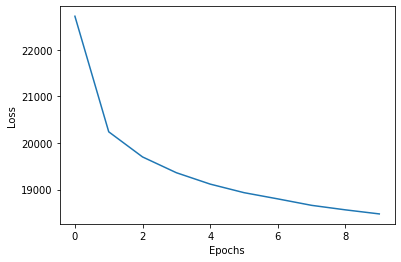

In [ ]:
vae.train()
training_loss = []
for _ in tqdm(range(10)):
    epoch_loss = 0
    num_batches = 0
    for X, _ in train_loader:
        X = X.to(device)
        X_reconstructed, X_latent_mean, X_latent_log_variance = vae(X)
        loss = vae_loss(X,X_reconstructed , X_latent_mean, X_latent_log_variance)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        num_batches += 1
    training_loss.append(epoch_loss / num_batches)
plt.ion()
fig = plt.figure()
plt.plot(training_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

6) Validate the model

In [ ]:
vae.eval()

test_loss_avg, num_batches = 0, 0
for X, _ in test_loader:
    with torch.no_grad():
        X = X.to(device)
        X_reconstructed, X_latent_mean, X_latent_log_variance = vae(X)
        loss = vae_loss( X,X_reconstructed, X_latent_mean, X_latent_log_variance)
        test_loss_avg += loss.item()
        num_batches += 1

test_loss_avg /= num_batches
print('Testing Loss: %f' % (test_loss_avg))

Testing Loss: 18318.383020


7) Sample random image

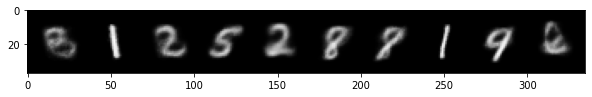

In [ ]:
vae.eval()
plt.ion()

def plot(img):
    img = img.clamp(0, 1).numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))

with torch.no_grad():
    random_noise_input = torch.randn(10, 2, device=device)
    image_generated_by_decoder = vae.decoder(random_noise_input)
    image_generated_by_decoder = image_generated_by_decoder.cpu()
    fig, ax = plt.subplots(figsize=(10, 20))
    plot(torchvision.utils.make_grid(image_generated_by_decoder.data,10,5))
    plt.show()